In [1]:
import ODE_models
import Model_stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Exploring a new payoff


In this notebook we will compare the usual Poletti model to one with altered payoff function. 

$$P_n = -m_n\left(1-q\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M - m_nM$$
$$P_a = -k-m_a\left(1-q\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M - m_aM$$

Here the $\left(1-q\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M$ indicates an individual's perception of how many asymptomatic infected individuals who are not acting with social distancing they might encounter. Thus here we are assuming that risk perception decreases as perception of many people observing altered behavior increases.

Note that in this implementation we still have $\frac{1}{m}$ as a parameter where $\frac{1}{m} = \frac{m_n-m_a}{k}$. Then the difference in payoff functions is given by:

$$\Delta P = 1 - m \left(2-q\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M$$

Important note: In Poletti's model, the baseline value for $p$ is 1 meaning that there are no asymptomatic individuals. In order for this altered payoff function to be different, we need $p\neq 1$.

### 1.  Baseline parameters

In order to compare this adjusted model with the original Poletti model, we must keep the parameters the same.

In [8]:
recovery_days = 2.8 # average length of infection (current baseline from 2012)
gamma = 1/recovery_days # rate of recovery

beta_S = 0.5 # infection rate for symptomatic infectives
beta_A = 0.5 # infection rate for asymptomatic infectives

q = 0.85  # reduction factor for those with altered/adjusted behavior
p = 1     # probability of developing symptoms

avg_memory = 2.8   # average length of memory regarding active cases
nu  = 1/avg_memory  # rate of forgetting past "new case" counts

M_thresh = 0.01 # risk threshold 
m = 1/M_thresh

rho = 10 # speed of behavioral changes (1/days)

mu = 10**(-8)  # irrational exploration with fixed units

params = ODE_models.get_params(p=0.6)

Now that we know we are using the baseline parameters that were used by Poletti, et. al. (at least in the 2012 paper), we are ready to simulate the model and plot the results. We will chose initial conditions from a reasonable estimation of the early stages of a pandemic.

In [9]:
## Set initial conditions
Sn_0  = (1 - 10**(-3))*(1-10**(-6))
Sa_0  = (1 - 10**(-3))*(10**(-6))
IS_0  = 10**(-3)
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0

# Simulate the ODE
initial_state = np.array([Sn_0,Sa_0,IS_0,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
time = np.arange(0,1000,0.005)

sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))

#### 1a. Basic Figures to check accuracy

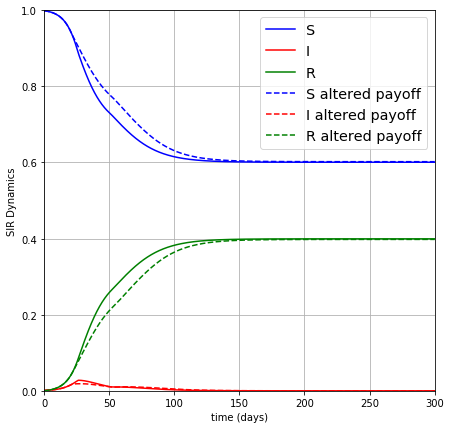

In [10]:
## Plot combined S, I, and R compartments. 

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

S = sim_system[:,0]+sim_system[:,1]
I = sim_system[:,2]+sim_system[:,3]+sim_system[:,4]
R = sim_system[:,5]+sim_system[:,6]+sim_system[:,7]

Sb = sim_system_payoffB[:,0]+sim_system_payoffB[:,1]
Ib = sim_system_payoffB[:,2]+sim_system_payoffB[:,3]+sim_system_payoffB[:,4]
Rb = sim_system_payoffB[:,5]+sim_system_payoffB[:,6]+sim_system_payoffB[:,7]

S_curve, = ax.plot(time, S, '-b',label='S')
I_curve, = ax.plot(time, I, '-r',label='I')
R_curve, = ax.plot(time, R, '-g',label='R')

Sb_curve, = ax.plot(time, Sb, '--b',label='S altered payoff')
Ib_curve, = ax.plot(time, Ib, '--r',label='I altered payoff')
Rb_curve, = ax.plot(time, Rb, '--g',label='R altered payoff')

ax.set(xlabel='time (days)', ylabel='SIR Dynamics')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend(loc='best',fontsize='x-large')

Text(0.5, 1.0, 'Poletti Model w/ behavior feedback payoff function')

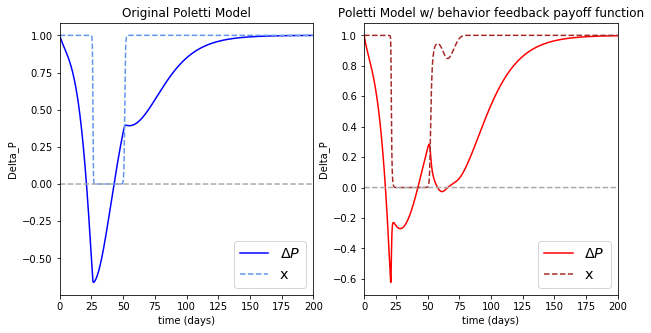

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

### Now we can look at what happens when we vary parameters. 

First of all, we can look at what how this compares to no intervension at all. And we can zoom in on the symptomatic infecteds.

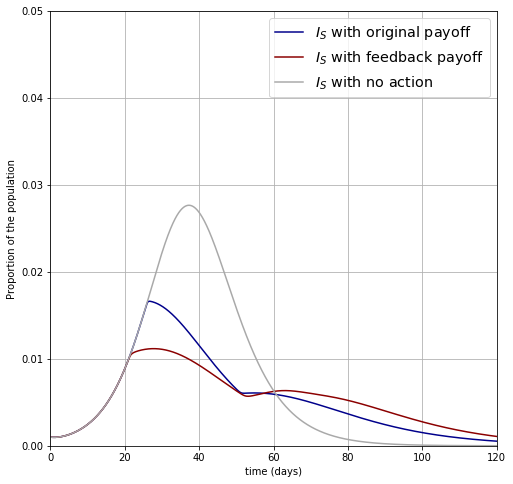

In [16]:
fin_time = 120

matplotlib.rcParams['figure.figsize'] = [8, 8]
fig, ax = plt.subplots()

I_S = sim_system[:,2]
I_Sb = sim_system_payoffB[:,2]

IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkblue', label=f'$I_S$ with original payoff')
ISb_curve, = ax.plot(time, I_Sb, linestyle='-', c='darkred', label=f'$I_S$ with feedback payoff')


# also plot what happens when the population is not responsive. 
params_noresponse = ODE_models.get_params(q=1,p=0.6)
noresponse_sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params_noresponse,))

IS_noresponse = noresponse_sim_system[:,2]
IS_noresponse_curve, = ax.plot(time, IS_noresponse, linestyle='-', c='darkgray', label=f'$I_S$ with no action')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,0.05))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend(loc='best',fontsize='x-large')

Now we can look at what happens when we vary some of the parameters as we did in Recreate_Poletti.

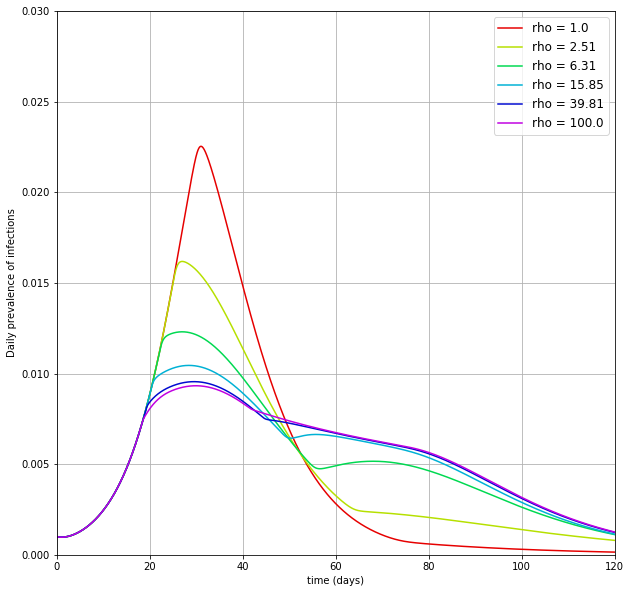

In [26]:
## Keep Poletti baseline but change rho

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.03))
ax.set_xlim((0,120))
ax.grid()

# test a time delay of 2 weeks vs 1 day. 
for i in np.linspace(0,2,6):
    rho_test = 10**i
    params = ODE_models.get_params(p=0.6,rho=rho_test)
    
    sim_system = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax.plot(time, sim_system[:,2], c=col, linestyle='-', label='rho = {}'.format(round(rho_test,2)))
    

ax.legend(loc='best',fontsize='large')

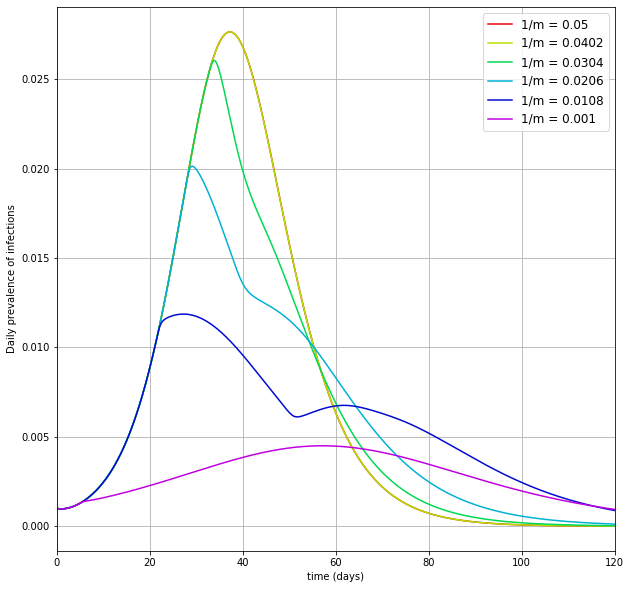

In [27]:
## Keep Poletti baseline but change rho

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
#ax.set_ylim((0,0.04))
ax.set_xlim((0,120))
ax.grid()

'''
    Note that even when there is no behavioral change, the peak is only 5/100 people. 
    So... we want to test values for 1/m that make sense and have some affect. 
    I tend to think about it as # of people out of 100 or 1000 or 10000.
    
    Let's test what happens when it's between 5:100 and 1:1000.
'''
for M_thresh_test in np.linspace(0.05,0.001,6):
    
    params = ODE_models.get_params(p=0.6,m=1/M_thresh_test)
    
    sim_system = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax.plot(time, sim_system[:,2], c=col, linestyle='-', label='1/m = {}'.format(round(M_thresh_test,4)))
    

ax.legend(loc='best',fontsize='large')

I'm not sure what happened to the curves for $1/m = 0.05$ or $1/m = 0.042$.

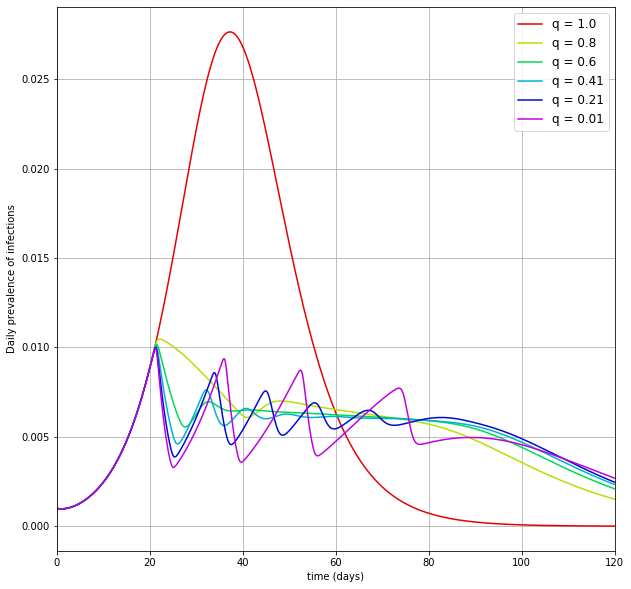

In [29]:
## Keep Poletti baseline but change rho

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
#ax.set_ylim((0,0.04))
ax.set_xlim((0,120))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(1,0.01,6):
    
    params = ODE_models.get_params(p=0.6,q=q_test)
    
    sim_system = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax.plot(time, sim_system[:,2], c=col, linestyle='-', label='q = {}'.format(round(q_test,2)))
    

ax.legend(loc='best',fontsize='large')